In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
df1=pd.read_csv('./mtcars.csv')
df1.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
#Dataset Attributes
df1 = df1.drop('model',axis=1)
df1.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [4]:
#Create Standard Model

#Define x and y variable
x = df1.drop('mpg',axis=1).values
y = df1['mpg'].values

#Train dataset using 20% test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Prepare Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor

alpha=0.5          

Model Evaluation - Accuracy Score
LinearRegression 3.67
Lasso 3.27
Ridge 3.27
ElasticNet 3.13
Random Forest 2.50
Bagging Regressor 2.74
AdaBoost 2.86
GBR 2.59
XGBR 2.65




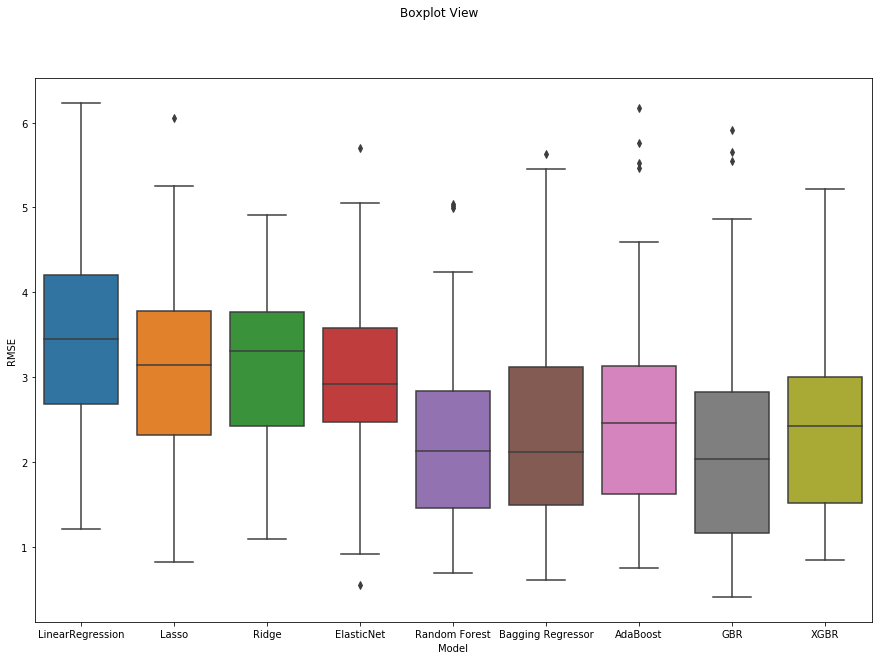

In [5]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LinearRegression',LinearRegression()))
models.append(('Lasso',Lasso(alpha=alpha,random_state=100)))
models.append(('Ridge',Ridge(alpha=alpha,random_state=100)))
models.append(('ElasticNet',ElasticNet(alpha=alpha,random_state=100)))
models.append(('Random Forest',RandomForestRegressor(n_estimators=100,
                                                     random_state=100)))
models.append(('Bagging Regressor',BaggingRegressor(random_state=100)))
models.append(('AdaBoost',AdaBoostRegressor(random_state=100)))
models.append(('GBR', GradientBoostingRegressor(random_state=100)))
models.append(('XGBR',XGBRegressor(objective= 'reg:squarederror',random_state=100)))
  
#Model Evaluation
results =[]
names=[]
scoring ='neg_mean_squared_error'
print('Model Evaluation - Accuracy Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,y,cv=rkf,scoring=scoring)
    results.append(np.sqrt(-cv_results))
    names.append(name)
    print('{} {:.2f}'.format(name,np.sqrt(-cv_results.mean())))
print('\n')

#Boxpot View
fig = plt.figure(figsize=(15,10))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

In [6]:
#Create Stacking Model
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

#Identify Models
lm = ElasticNet(alpha=alpha,random_state=100)
mod1 = RandomForestRegressor(n_estimators=100,
                             random_state=100)
mod2 = GradientBoostingRegressor(random_state=100)

#Create Stacking Classifier
np.random.seed(100)
stackmod=StackingCVRegressor(regressors=[mod1,mod2],
                             meta_regressor=lm)

scoring = {'MAE':'neg_mean_absolute_error',
           'MSE':'neg_mean_squared_error'}

print('Stacking Model')
for clf in (mod1,mod2,stackmod):
    rkfcv= clf.fit(x_train2,y_train)
    ens_rkf1 = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    rKFcv = cross_validate(rkfcv, x_2, y, scoring=scoring, cv=ens_rkf1)
    print(clf.__class__.__name__,round(np.sqrt(-rKFcv['test_MSE'].mean()),2))  

Stacking Model
RandomForestRegressor 2.5
GradientBoostingRegressor 2.59
StackingCVRegressor 2.57
